### [Conditional Variational Autoencoder (VAE)](https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb)

In [1]:
import warnings
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scipy.misc import imsave
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Data import
# MNIST data is separated into training and test partitions, with separate X (pixel representation) and y (label value)
# The X matrices are 28x28 numpy arrays, while the y is just an integer.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
# Reshaping
# Properly represent the pixel information contained in X to a fully-connected feed forward neural network
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

In [4]:
# Properly represent the label y
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [5]:
# Hyperparameters
m = 250 # batch size
n_z = 2 # latent space size
encoder_dim1 = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.001)


n_x = X_train.shape[1]
n_y = y_train.shape[1]


n_epoch = 50

In [6]:
# The encoder
X = Input(shape=(n_x,))
label = Input(shape=(n_y,))

inputs = concat([X, label])

encoder_h = Dense(encoder_dim1, activation=activ)(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

In [10]:
# The latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with label
zc = concat([z, label])

In [11]:
# Decoder
decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [12]:
# Defining loss
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
	return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [13]:
# Defining the graphs
cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [14]:
# Training
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])

In [15]:
# compile and fit
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=n_epoch,
							validation_data = ([X_test, y_test], X_test),
							callbacks = [EarlyStopping(patience = 5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s - loss: 198.5605 - KL_loss: 9.2840 - recon_loss: 189.2765 - val_loss: 154.5540 - val_KL_loss: 4.7290 - val_recon_loss: 149.8251
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 148.7884 - KL_loss: 4.4363 - recon_loss: 144.3522 - val_loss: 144.2921 - val_KL_loss: 4.2789 - val_recon_loss: 140.0132
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 142.8696 - KL_loss: 4.2707 - recon_loss: 138.5989 - val_loss: 141.2003 - val_KL_loss: 4.3155 - val_recon_loss: 136.8848
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 140.4333 - KL_loss: 4.2716 - recon_loss: 136.1617 - val_loss: 139.4493 - val_KL_loss: 4.2255 - val_recon_loss: 135.2238
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 138.9394 - KL_loss: 4.2724 - recon_loss: 134.6669 - val_loss: 138.1692 - val_KL_loss: 4.1830 - val_recon_loss: 133.9862
Epoch

60000/60000 [==============================] - 1s - loss: 129.8415 - KL_loss: 4.7006 - recon_loss: 125.1409 - val_loss: 130.9835 - val_KL_loss: 4.5907 - val_recon_loss: 126.3928
Epoch 44/50
60000/60000 [==============================] - 1s - loss: 129.7658 - KL_loss: 4.7099 - recon_loss: 125.0559 - val_loss: 130.8835 - val_KL_loss: 4.6845 - val_recon_loss: 126.1990
Epoch 45/50
60000/60000 [==============================] - 1s - loss: 129.6964 - KL_loss: 4.7125 - recon_loss: 124.9839 - val_loss: 130.9387 - val_KL_loss: 4.5784 - val_recon_loss: 126.3604
Epoch 46/50
60000/60000 [==============================] - 1s - loss: 129.6490 - KL_loss: 4.7272 - recon_loss: 124.9218 - val_loss: 130.8578 - val_KL_loss: 4.5969 - val_recon_loss: 126.2610
Epoch 47/50
60000/60000 [==============================] - 1s - loss: 129.5759 - KL_loss: 4.7186 - recon_loss: 124.8573 - val_loss: 130.9210 - val_KL_loss: 4.6908 - val_recon_loss: 126.2302
Epoch 48/50
60000/60000 [==============================] - 1s 

### Exploring the model
The latent space should hopefully contain some interesting structural information about the digits we're autoencoding. That's the case in any autoencoding network, but in a VAE the spatial arrangement should make more intuitive 'sense' since the noise added to the latent space representation forces the model to create useful respresentations.

#### Generating a latent space representation with the encoder
First let's see concretely what happens when we pass an image and class to the encoder. We can take a look at the first image in the training set:

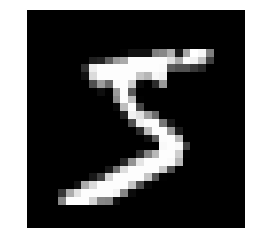

In [16]:
# Generating a latent space representation with the encoder
# see what happens when we pass an image and class to the encoder
# take a look at the first image in the training set
plt.imshow(X_train[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

In [17]:
# image is 5, the first image in the training set also says it is 5 by the truth label
print(Y_train[0])

5


In [18]:
# how model represents that same digit in the latent space by passing it through the encoder
encoded_X0 = encoder.predict([X_train[0].reshape((1, 784)), y_train[0].reshape((1, 10))])
print(encoded_X0)

[[-0.02542629  0.3583132 ]]


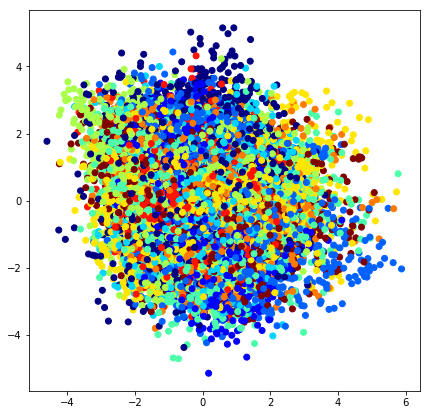

In [19]:
# Since we append the class label directly to the latent space representation, 
    # our network doesn't need to store any information about which digit it generates in the latent space
# encode our whole training set
z_train = encoder.predict([X_train, y_train])
encodings= np.asarray(z_train)
encodings = encodings.reshape(X_train.shape[0], n_z)
plt.figure(figsize=(7, 7))
plt.scatter(encodings[:, 0], encodings[:, 1], c=Y_train, cmap=plt.cm.jet)
plt.show()
# all of the digits (represented by the different colors) are pretty much layered on top of each other and are distributed approximately bivariate normal
# this is what we would expect to happen.

In [20]:
# Generating a digit
def construct_numvec(digit, z = None):
    out = np.zeros((1, n_z + n_y))
    out[:, digit + n_z] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)
    
sample_3 = construct_numvec(3)
print(sample_3)

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]


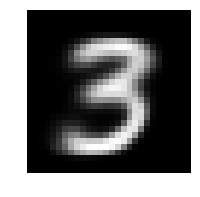

In [21]:
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict(sample_3).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

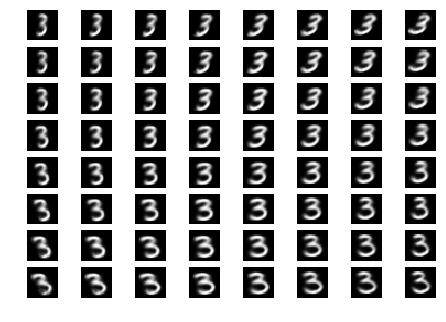

In [22]:
# Exploring the latent space variables
dig = 3
sides = 8
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()
# As z1 changes (on the y-axis), the digit style becomes narrower
# Varying the value of z2 (on the x-axis) appears to rotate the digit slightly and elongate the lower portion in relation to the upper portion
# There appears to be some interaction between the two values.

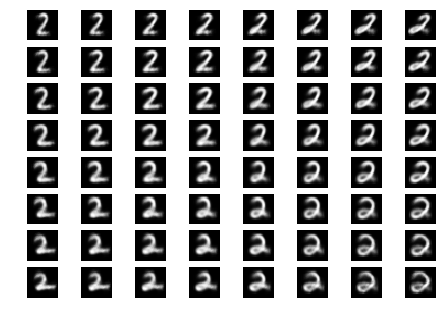

In [23]:
dig = 2
sides = 8
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()
# The latent variable appears to control the "style" of the digit